## Install dependencies

In [1]:

!pip install -q transformers torch torchvision datasets roboflow pillow scikit-learn matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 78.5 MB/s eta 0:00:00


In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [3]:
from roboflow import Roboflow

rf = Roboflow(api_key="use-your-own-API-key")

# Dataset 1: Taping areas
project1 = rf.workspace("objectdetect-pu6rn").project("drywall-join-detect")
dataset1 = project1.version(1).download("coco")
print(f"Dataset 1 location: {dataset1.location}")

# Dataset 2: Cracks ( since I was unable to access the cracks data, i forked the dataset and created version1 out of it)
project2 = rf.workspace("subho").project("cracks-3ii36-xlq5h")
dataset2 = project2.version(1).download("coco")
print(f"Dataset 2 location: {dataset2.location}")

print("Both datasets downloaded successfully")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drywall-Join-Detect-1 in coco:: 100%|██████████| 1192/1192 [00:00<00:00, 8413.27it/s]


Dataset 1 location: /content/Drywall-Join-Detect-1
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cracks-1 in coco:: 100%|██████████| 5377/5377 [00:03<00:00, 1719.09it/s]


Dataset 2 location: /content/cracks-1
Both datasets downloaded successfully


Loading Dataset 1: Taping areas...
Loading Dataset 2: Cracks...
Dataset Statistics:
Taping Areas - Train: 936, Val: 250
Cracks       - Train: 5164, Val: 201
Total        - Train: 6100, Val: 451


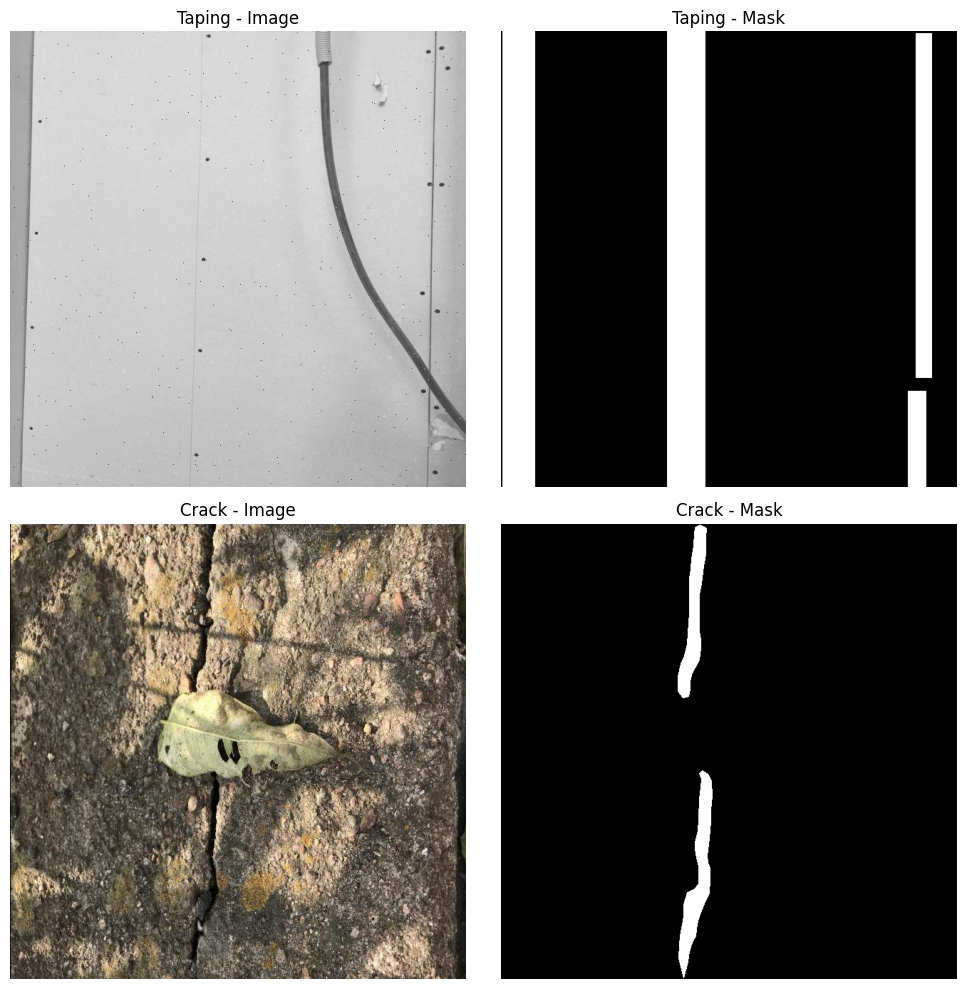


 Datasets loaded successfully!


In [5]:
import json
import numpy as np
import cv2
from PIL import Image

def load_coco_data(json_path, img_dir):
    with open(json_path, 'r') as f:
        coco = json.load(f)

    # Build image id to info mapping
    images = {img['id']: img for img in coco['images']}

    # Group annotations by image
    img_annotations = {}
    for ann in coco['annotations']:
        img_id = ann['image_id']
        if img_id not in img_annotations:
            img_annotations[img_id] = []
        img_annotations[img_id].append(ann)

    data = []
    for img_id, anns in img_annotations.items():
        img_info = images[img_id]
        img_path = os.path.join(img_dir, img_info['file_name'])

        if not os.path.exists(img_path):
            continue

        h, w = img_info['height'], img_info['width']
        mask = np.zeros((h, w), dtype=np.uint8)

        for ann in anns:
            # Try to use polygon segmentation if available
            if 'segmentation' in ann and isinstance(ann['segmentation'], list) and len(ann['segmentation']) > 0:
                # Polygon segmentation
                for seg in ann['segmentation']:
                    if len(seg) >= 6:  # Valid polygon needs at least 3 points
                        poly = np.array(seg).reshape(-1, 2).astype(np.int32)
                        cv2.fillPoly(mask, [poly], 255)

            # Fallback to bounding box if no segmentation
            elif 'bbox' in ann:
                x, y, bw, bh = [int(v) for v in ann['bbox']]
                # Ensure bbox is within image bounds
                x = max(0, min(x, w-1))
                y = max(0, min(y, h-1))
                bw = max(1, min(bw, w-x))
                bh = max(1, min(bh, h-y))
                mask[y:y+bh, x:x+bw] = 255

        # if mask has content
        if mask.sum() > 0:
            data.append({
                'image_path': img_path,
                'mask': mask,
                'width': w,
                'height': h
            })

    return data

# Load both datasets
print("Loading Dataset 1: Taping areas...")
taping_train = load_coco_data(
    f"{dataset1.location}/train/_annotations.coco.json",
    f"{dataset1.location}/train"
)
taping_val = load_coco_data(
    f"{dataset1.location}/valid/_annotations.coco.json",
    f"{dataset1.location}/valid"
)

print("Loading Dataset 2: Cracks...")
crack_train = load_coco_data(
    f"{dataset2.location}/train/_annotations.coco.json",
    f"{dataset2.location}/train"
)
crack_val = load_coco_data(
    f"{dataset2.location}/valid/_annotations.coco.json",
    f"{dataset2.location}/valid"
)

print("Dataset Statistics:")
print(f"Taping Areas - Train: {len(taping_train)}, Val: {len(taping_val)}")
print(f"Cracks       - Train: {len(crack_train)}, Val: {len(crack_val)}")
print(f"Total        - Train: {len(taping_train) + len(crack_train)}, Val: {len(taping_val) + len(crack_val)}")

# sanity check
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Taping sample
if len(taping_train) > 0:
    sample = taping_train[0]
    img = Image.open(sample['image_path'])
    axes[0, 0].imshow(img)
    axes[0, 0].set_title("Taping - Image")
    axes[0, 0].axis('off')
    axes[0, 1].imshow(sample['mask'], cmap='gray')
    axes[0, 1].set_title("Taping - Mask")
    axes[0, 1].axis('off')

# Crack sample
if len(crack_train) > 0:
    sample = crack_train[0]
    img = Image.open(sample['image_path'])
    axes[1, 0].imshow(img)
    axes[1, 0].set_title("Crack - Image")
    axes[1, 0].axis('off')
    axes[1, 1].imshow(sample['mask'], cmap='gray')
    axes[1, 1].set_title("Crack - Mask")
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('dataset_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Datasets loaded successfully!")

In [6]:
def custom_collate_fn(batch):
    """
    Custom collate function to handle variable-length text inputs.
    Rebatch using the processor to ensure consistent padding.
    """
    # Extract all prompts and process them together for consistent padding
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])

    # Get the longest sequence in this batch for proper padding
    input_ids_list = [item['input_ids'] for item in batch]
    attention_mask_list = [item['attention_mask'] for item in batch]

    # Pad to the same length within this batch
    max_len = max(ids.shape[0] for ids in input_ids_list)

    padded_input_ids = []
    padded_attention_mask = []

    for ids, mask in zip(input_ids_list, attention_mask_list):
        # Pad to max_len
        pad_len = max_len - ids.shape[0]
        if pad_len > 0:
            ids = torch.cat([ids, torch.zeros(pad_len, dtype=ids.dtype)])
            mask = torch.cat([mask, torch.zeros(pad_len, dtype=mask.dtype)])
        padded_input_ids.append(ids)
        padded_attention_mask.append(mask)

    input_ids = torch.stack(padded_input_ids)
    attention_mask = torch.stack(padded_attention_mask)

    return {
        'pixel_values': pixel_values,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

class PromptedSegmentationDataset(Dataset):
    """
    Dataset for text-prompted segmentation.
    Each sample consists of an image, a text prompt, and a binary mask.
    """

    def __init__(self, data_dict, processor, augment=False):
        """
        Args:
            data_dict: dict mapping prompt to list of data samples
            processor: CLIPSegProcessor for preprocessing
            augment: whether to apply horizontal flip augmentation
        """
        self.processor = processor
        self.augment = augment

        # Flatten data with associated prompts
        self.samples = []
        for prompt, data_list in data_dict.items():
            for item in data_list:
                self.samples.append({
                    'image_path': item['image_path'],
                    'mask': item['mask'],
                    'prompt': prompt
                })

        print(f"Created dataset with {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load image
        image = Image.open(sample['image_path']).convert('RGB')
        mask = sample['mask']
        prompt = sample['prompt']

        # Simple augmentation: horizontal flip
        if self.augment and np.random.random() > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = np.fliplr(mask).copy()

        # Process inputs with CLIPSeg processor
        inputs = self.processor(
            text=[prompt],
            images=[image],
            padding=True,
            return_tensors="pt"
        )

        # Remove batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Resize mask to match CLIPSeg output size (352x352)
        mask_resized = Image.fromarray(mask).resize((352, 352), Image.NEAREST)
        mask_tensor = torch.from_numpy(np.array(mask_resized)).float() / 255.0

        inputs['labels'] = mask_tensor

        return inputs

# Define prompt variations for each task
PROMPT_VARIATIONS = {
    'taping': ["segment taping area", "segment joint", "segment drywall seam"],
    'crack': ["segment crack", "segment wall crack"]
}

# Create combined datasets with prompt variations
train_data = {}
val_data = {}

for prompt in PROMPT_VARIATIONS['taping']:
    train_data[prompt] = taping_train
    val_data[prompt] = taping_val

for prompt in PROMPT_VARIATIONS['crack']:
    train_data[prompt] = crack_train
    val_data[prompt] = crack_val

# Initialize CLIPSeg processor
print("Loading CLIPSeg processor...")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")

# Create datasets
print("\nCreating training dataset...")
train_dataset = PromptedSegmentationDataset(train_data, processor, augment=True)

print("Creating validation dataset...")
val_dataset = PromptedSegmentationDataset(val_data, processor, augment=False)

print("Dataset Summary:")
print(f"Training samples:   {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Prompts used:")
for task, prompts in PROMPT_VARIATIONS.items():
    print(f"  {task.capitalize()}: {prompts}")


# Test dataset by loading one sample
print("\nTesting dataset loading...")
sample = train_dataset[0]
print(f"Sample keys: {sample.keys()}")
print(f"Image shape: {sample['pixel_values'].shape}")
print(f"Prompt IDs shape: {sample['input_ids'].shape}")
print(f"Label shape: {sample['labels'].shape}")
print(" Dataset created successfully!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading CLIPSeg processor...


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]


Creating training dataset...
Created dataset with 13136 samples
Creating validation dataset...
Created dataset with 1152 samples
Dataset Summary:
Training samples:   13136
Validation samples: 1152
Prompts used:
  Taping: ['segment taping area', 'segment joint', 'segment drywall seam']
  Crack: ['segment crack', 'segment wall crack']

Testing dataset loading...
Sample keys: dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'labels'])
Image shape: torch.Size([3, 352, 352])
Prompt IDs shape: torch.Size([5])
Label shape: torch.Size([352, 352])
 Dataset created successfully!


In [7]:
def compute_iou(pred, target, threshold=0.5):
    """
    Compute Intersection over Union (IoU) metric.

    Args:
        pred: predicted mask (float tensor)
        target: ground truth mask (float tensor)
        threshold: threshold for binarization

    Returns:
        IoU score (float)
    """
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()

    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection

    # Add small epsilon to avoid division by zero
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

def compute_dice(pred, target, threshold=0.5):
    """
    Compute Dice coefficient (F1 score for segmentation).

    Args:
        pred: predicted mask (float tensor)
        target: ground truth mask (float tensor)
        threshold: threshold for binarization

    Returns:
        Dice score (float)
    """
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()

    intersection = (pred_binary * target_binary).sum()
    dice = (2 * intersection + 1e-6) / (pred_binary.sum() + target_binary.sum() + 1e-6)

    return dice.item()

def evaluate_model(model, dataloader, device):
    """
    Evaluate model on a dataloader and compute average metrics.

    Args:
        model: segmentation model
        dataloader: validation/test dataloader
        device: cuda or cpu

    Returns:
        mean_iou, mean_dice
    """
    model.eval()
    total_iou = 0
    total_dice = 0
    count = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Get predictions and apply sigmoid
            preds = torch.sigmoid(outputs.logits)

            # Compute metrics for each sample in batch
            for pred, target in zip(preds, labels):
                total_iou += compute_iou(pred, target)
                total_dice += compute_dice(pred, target)
                count += 1

    mean_iou = total_iou / count
    mean_dice = total_dice / count

    return mean_iou, mean_dice


In [8]:
# Training hyperparameters
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15
WEIGHT_DECAY = 0.01

print("Creating dataloaders...")
# Create dataloaders with custom collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

print("Loading CLIPSeg model...")

model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
model = model.to(device)

print("Setting up optimizer and loss...")
# Setup optimizer and loss function
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

criterion = nn.BCEWithLogitsLoss()

# Cosine annealing learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS
)

# Calculate model size
model_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Training Configuration:")
print(f"Batch size:        {BATCH_SIZE}")
print(f"Learning rate:     {LEARNING_RATE}")
print(f"Epochs:            {NUM_EPOCHS}")
print(f"Weight decay:      {WEIGHT_DECAY}")
print(f"Optimizer:         AdamW")
print(f"LR scheduler:      CosineAnnealingLR")
print(f"Loss function:     BCEWithLogitsLoss")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
print(f"Model parameters:  {model_params / 1e6:.2f}M")
print(f"Trainable params:  {trainable_params / 1e6:.2f}M")
print(f"Training batches:  {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Creating dataloaders...
Loading CLIPSeg model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]

Setting up optimizer and loss...
Training Configuration:
Batch size:        8
Learning rate:     0.0001
Epochs:            15
Weight decay:      0.01
Optimizer:         AdamW
LR scheduler:      CosineAnnealingLR
Loss function:     BCEWithLogitsLoss
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Model parameters:  150.75M
Trainable params:  150.75M
Training batches:  1642
Validation batches: 144


In [17]:
import time

# Training history
history = {
    'train_loss': [],
    'val_iou': [],
    'val_dice': []
}

best_dice = 0
start_time = time.time()

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for batch in pbar:
        # Move to device
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Compute loss
        loss = criterion(outputs.logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    val_iou, val_dice = evaluate_model(model, val_loader, device)

    # Update scheduler
    scheduler.step()

    # Save history
    history['train_loss'].append(avg_train_loss)
    history['val_iou'].append(val_iou)
    history['val_dice'].append(val_dice)

    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Loss: {avg_train_loss:.4f} | Val IoU: {val_iou:.4f} | Val Dice: {val_dice:.4f}")

    # Save best model
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), 'best.pt')
        print(f"Saved best.pt (Dice: {best_dice:.4f})")

# Save last checkpoint
torch.save(model.state_dict(), 'last.pt')

training_time = time.time() - start_time


print("Training Complete!")
print(f"Total time: {training_time/60:.2f} minutes")
print(f"Best Dice:  {best_dice:.4f}")
print(f"Final IoU:  {history['val_iou'][-1]:.4f}")
print(f"Final Dice: {history['val_dice'][-1]:.4f}")
print("\n Saved checkpoints: best.pt, last.pt")

Starting training...



Epoch 1/15:   0%|          | 0/1642 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]


Epoch 1/15
  Loss: 0.0672 | Val IoU: 0.5236 | Val Dice: 0.6673
Saved best.pt (Dice: 0.6673)


Epoch 2/15:   0%|          | 0/1642 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]


Epoch 2/15
  Loss: 0.0645 | Val IoU: 0.5420 | Val Dice: 0.6824
Saved best.pt (Dice: 0.6824)


Epoch 3/15:   0%|          | 0/1642 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]


Epoch 3/15
  Loss: 0.0617 | Val IoU: 0.5578 | Val Dice: 0.6972
Saved best.pt (Dice: 0.6972)


Epoch 4/15:   0%|          | 0/1642 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba03f34dee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
   Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba03f34dee0> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    ^if w.is_alive():
^  ^ ^ ^ ^  ^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^   ^ 
   File "/usr/lib/p

Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]


Epoch 4/15
  Loss: 0.0591 | Val IoU: 0.5503 | Val Dice: 0.6911


Epoch 5/15:   0%|          | 0/1642 [00:00<?, ?it/s]

KeyboardInterrupt: 

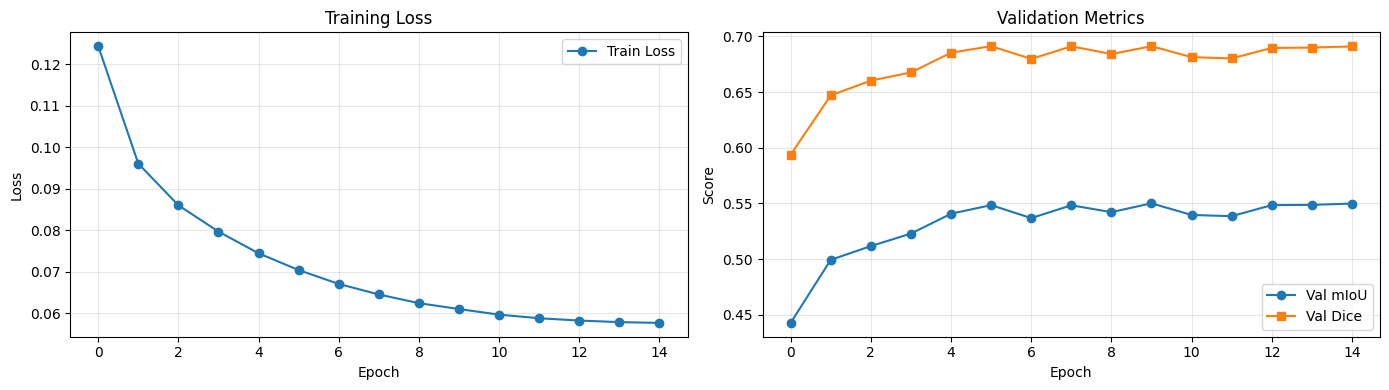

Training history plot saved to training_history.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Metrics plot
axes[1].plot(history['val_iou'], label='Val mIoU', marker='o')
axes[1].plot(history['val_dice'], label='Val Dice', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history plot saved to training_history.png")

In [10]:
# Load best model
model.load_state_dict(torch.load('best.pt'))
model.eval()

def predict_mask(image_path, prompt, model, processor, device, original_size=None):
    """
    Generate prediction mask for given image and prompt.
    Returns binary mask at original image size with values {0, 255}.
    """
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    if original_size is None:
        original_size = image.size[::-1]  # (height, width)

    inputs = processor(
        text=[prompt],
        images=[image],
        padding=True,
        return_tensors="pt"
    )

    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.sigmoid(outputs.logits)

    # Convert to numpy and resize to original size
    mask = preds.squeeze().cpu().numpy()
    mask_resized = Image.fromarray((mask * 255).astype(np.uint8)).resize(
        (original_size[1], original_size[0]),
        Image.BILINEAR
    )
    mask_binary = (np.array(mask_resized) > 127).astype(np.uint8) * 255

    return mask_binary

# Test inference time
test_sample = val_dataset.samples[0]
test_image_path = test_sample['image_path']
test_prompt = test_sample['prompt']

start = time.time()
for _ in range(10):
    _ = predict_mask(test_image_path, test_prompt, model, processor, device)
avg_inference_time = (time.time() - start) / 10

print(f"Average inference time: {avg_inference_time*1000:.2f} ms per image")

Average inference time: 57.09 ms per image


In [11]:
import os

# Create output directory
os.makedirs('predictions', exist_ok=True)

def save_prediction(image_path, prompt, mask, output_dir='predictions'):
    """
    Save prediction mask as PNG with proper filename format.
    Format: <image_id>__<prompt>.png
    """
    # Extract image id from path
    image_id = os.path.splitext(os.path.basename(image_path))[0]

    # Clean prompt for filename
    prompt_clean = prompt.replace(' ', '_').replace('/', '_')

    # Save mask
    filename = f"{image_id}__{prompt_clean}.png"
    output_path = os.path.join(output_dir, filename)

    Image.fromarray(mask).save(output_path)
    return output_path

# Generate predictions for all validation samples
print("Generating predictions for validation set...")
prediction_paths = []

for sample in tqdm(val_dataset.samples):
    mask_pred = predict_mask(
        sample['image_path'],
        sample['prompt'],
        model,
        processor,
        device,
        original_size=sample['mask'].shape
    )

    output_path = save_prediction(
        sample['image_path'],
        sample['prompt'],
        mask_pred
    )
    prediction_paths.append(output_path)

print(f"Saved {len(prediction_paths)} prediction masks to ./predictions/")

Generating predictions for validation set...


  0%|          | 0/1152 [00:00<?, ?it/s]

Saved 1152 prediction masks to ./predictions/


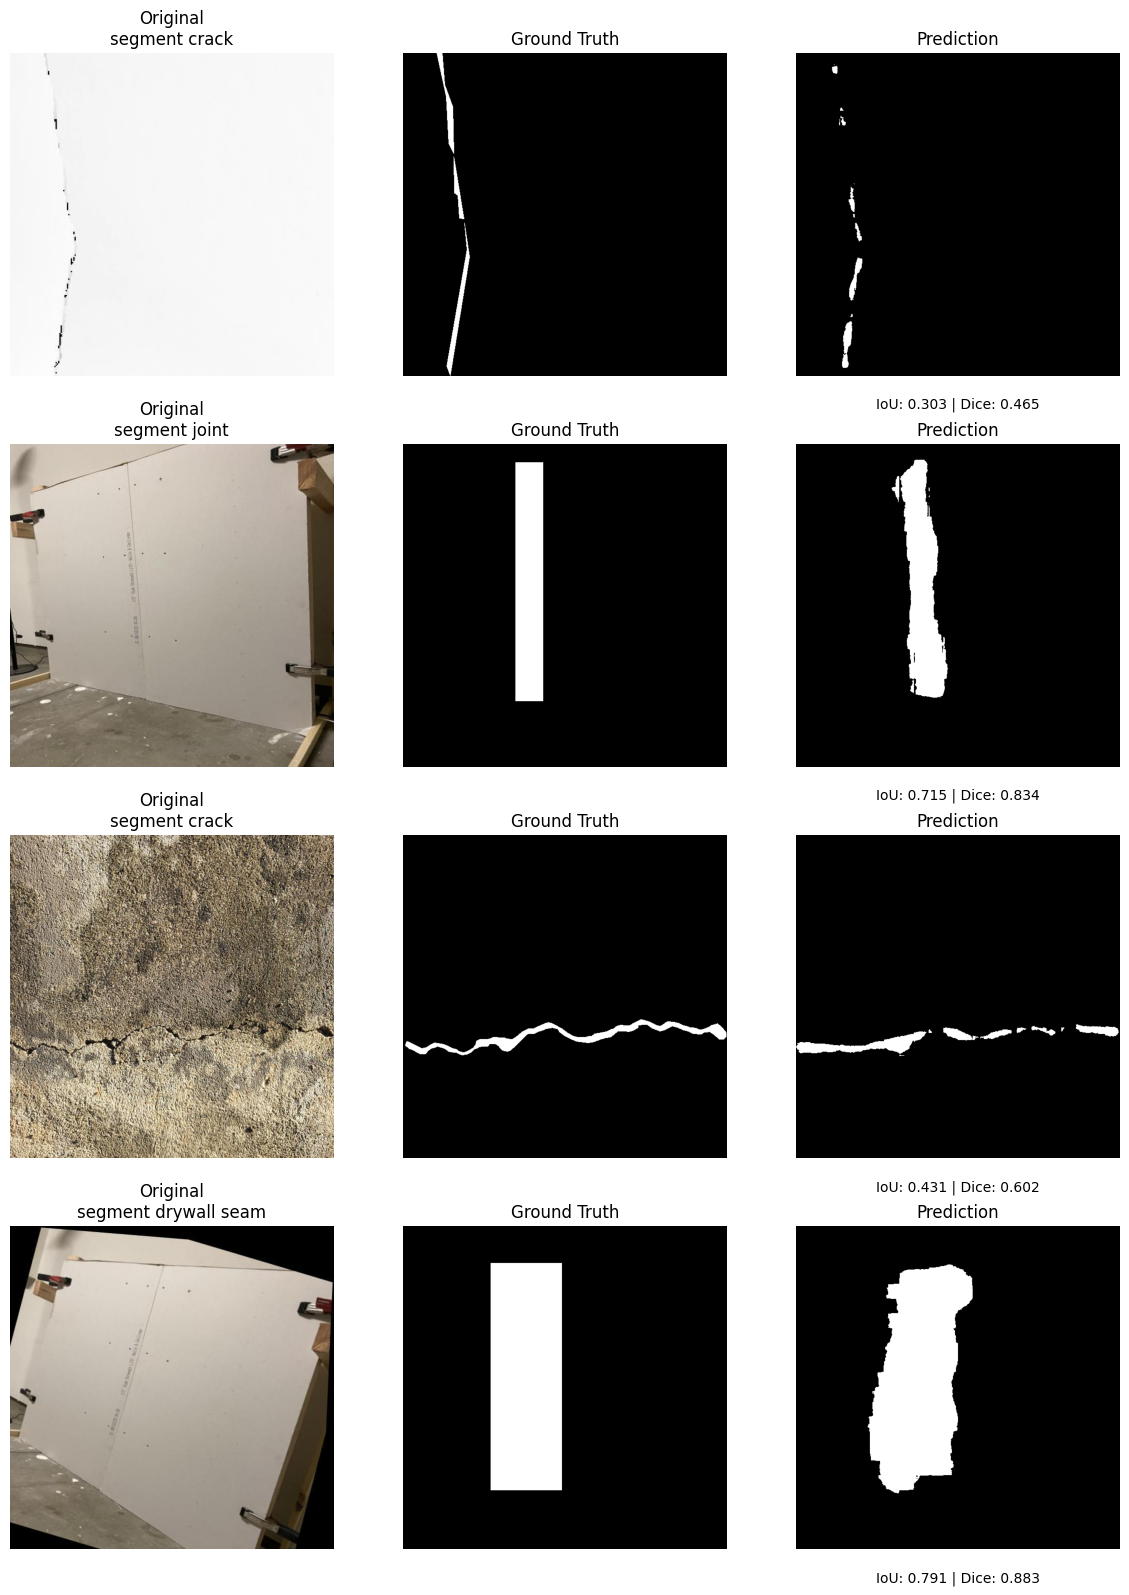

In [12]:
def visualize_predictions(num_samples=4):
    """
    Visualize original image, ground truth, and prediction.
    Format: Original | Ground Truth | Prediction
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    # Sample random indices from validation set
    indices = np.random.choice(len(val_dataset.samples), num_samples, replace=False)

    for i, idx in enumerate(indices):
        sample = val_dataset.samples[idx]

        # Load image
        image = Image.open(sample['image_path']).convert('RGB')
        gt_mask = sample['mask']

        # Generate prediction
        pred_mask = predict_mask(
            sample['image_path'],
            sample['prompt'],
            model,
            processor,
            device,
            original_size=gt_mask.shape
        )

        # Plot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Original\n{sample['prompt']}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gt_mask, cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')

        # Compute metrics
        iou = compute_iou(
            torch.from_numpy(pred_mask/255.0),
            torch.from_numpy(gt_mask/255.0)
        )
        dice = compute_dice(
            torch.from_numpy(pred_mask/255.0),
            torch.from_numpy(gt_mask/255.0)
        )

        axes[i, 2].text(
            0.5, -0.1, f"IoU: {iou:.3f} | Dice: {dice:.3f}",
            transform=axes[i, 2].transAxes,
            ha='center', fontsize=10
        )

    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_predictions(num_samples=4)

## Detailed Evaluation by Prompt

In [13]:
def evaluate_by_prompt(model, dataset, processor, device):
    """
    Evaluate model separately for each prompt type.
    Returns metrics grouped by prompt.
    """
    results = {}

    # Group samples by prompt
    prompt_samples = {}
    for sample in dataset.samples:
        prompt = sample['prompt']
        if prompt not in prompt_samples:
            prompt_samples[prompt] = []
        prompt_samples[prompt].append(sample)

    # Evaluate each prompt
    for prompt, samples in prompt_samples.items():
        ious = []
        dices = []

        for sample in tqdm(samples, desc=f"Evaluating '{prompt}'"):
            # Generate prediction
            pred_mask = predict_mask(
                sample['image_path'],
                prompt,
                model,
                processor,
                device,
                original_size=sample['mask'].shape
            )

            # Compute metrics
            iou = compute_iou(
                torch.from_numpy(pred_mask/255.0),
                torch.from_numpy(sample['mask']/255.0)
            )
            dice = compute_dice(
                torch.from_numpy(pred_mask/255.0),
                torch.from_numpy(sample['mask']/255.0)
            )

            ious.append(iou)
            dices.append(dice)

        results[prompt] = {
            'mIoU': np.mean(ious),
            'mDice': np.mean(dices),
            'std_iou': np.std(ious),
            'std_dice': np.std(dices),
            'count': len(samples)
        }

    return results

# Evaluate on validation set
print("\nDetailed evaluation by prompt:")
prompt_results = evaluate_by_prompt(model, val_dataset, processor, device)

# Print results table
print("\n" + "="*80)
print(f"{'Prompt':<40} {'Count':<10} {'mIoU':<12} {'mDice':<12}")
print("="*80)
for prompt, metrics in prompt_results.items():
    print(f"{prompt:<40} {metrics['count']:<10} {metrics['mIoU']:<12.4f} {metrics['mDice']:<12.4f}")
print("="*80)

# Overall average
overall_iou = np.mean([m['mIoU'] for m in prompt_results.values()])
overall_dice = np.mean([m['mDice'] for m in prompt_results.values()])
print(f"{'Overall Average':<40} {'':<10} {overall_iou:<12.4f} {overall_dice:<12.4f}")
print("="*80)

# Group by task type
taping_prompts = [p for p in prompt_results.keys() if 'taping' in p.lower() or 'joint' in p.lower() or 'seam' in p.lower()]
crack_prompts = [p for p in prompt_results.keys() if 'crack' in p.lower()]

taping_iou = np.mean([prompt_results[p]['mIoU'] for p in taping_prompts])
taping_dice = np.mean([prompt_results[p]['mDice'] for p in taping_prompts])
crack_iou = np.mean([prompt_results[p]['mIoU'] for p in crack_prompts])
crack_dice = np.mean([prompt_results[p]['mDice'] for p in crack_prompts])

print(f"\nTask-level metrics:")
print(f"Taping Area - mIoU: {taping_iou:.4f}, mDice: {taping_dice:.4f}")
print(f"Cracks      - mIoU: {crack_iou:.4f}, mDice: {crack_dice:.4f}")


Detailed evaluation by prompt:


Evaluating 'segment taping area':   0%|          | 0/250 [00:00<?, ?it/s]

Evaluating 'segment joint':   0%|          | 0/250 [00:00<?, ?it/s]

Evaluating 'segment drywall seam':   0%|          | 0/250 [00:00<?, ?it/s]

Evaluating 'segment crack':   0%|          | 0/201 [00:00<?, ?it/s]

Evaluating 'segment wall crack':   0%|          | 0/201 [00:00<?, ?it/s]


Prompt                                   Count      mIoU         mDice       
segment taping area                      250        0.5837       0.7243      
segment joint                            250        0.5857       0.7262      
segment drywall seam                     250        0.5798       0.7212      
segment crack                            201        0.4873       0.6329      
segment wall crack                       201        0.4825       0.6284      
Overall Average                                     0.5438       0.6866      

Task-level metrics:
Taping Area - mIoU: 0.5831, mDice: 0.7239
Cracks      - mIoU: 0.4849, mDice: 0.6307


In [18]:
# Zip the predictions folder and download
from google.colab import files
import shutil

shutil.make_archive('predictions', 'zip', '/content/predictions')
files.download('predictions.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>